## 传统网络骨架的缺陷
前面几节的网络骨架，如VGGNet和ResNet等，虽从各个角度出发提升了物体检测性能，但究其根本是为ImageNet的图像分类任务而设计的。而**图像分类与物体检测两个任务天然存在着落差，分类任务侧重于全图的特征提取，深层的特征图分辨率很低；而物体检测需要定位出物体位置，特征图分辨率不宜过小**，因此造成了以下两种缺陷。

### ①大物体难以定位
对于FPN等网络，大物体对应在较深的特征图上检测，由于网络较深时下采样率较大，物体的边缘难以精确预测，增加了回归边界的难度。

### ②小物体难以检测
对于传统网络，由于下采样率大造成小物体在较深的特征图上几乎不可见；FPN虽从较浅的特征图来检测小物体，但浅层的语义信息较弱，且融合深层特征时使用的上采样操作也会增加物体检测的难度。

## DetNet
针对以上问题，旷视科技提出了专为物体检测设计的DetNet结构，引入了空洞卷积，使得模型兼具较大感受野与较高分辨率，同时避免了3.6节中FPN的多次上采样，实现了较好的检测效果。DetNet的网络结构如下图所示，仍然选择性能优越的ResNet-50作为基础结构，并保持前4个stage与ResNet-50相同，具体的结构细节有以下3点：

①引入了一个新的Stage 6，用于物体检测。Stage 5与Stage 6使用了DetNet提出的Bottleneck结构，最大的特点是利用空洞数为2的3×3卷积取代了步长为2的3×3卷积。

②Stage 5与Stage 6的每一个Bottleneck输出的特征图尺寸都为原图的1/16，通道数都为256，而传统的Backbone通常是特征图尺寸递减，通道数递增。

③在组成特征金字塔时，由于特征图大小完全相同，因此可以直接从右向左传递相加，避免了上一节的上采样操作。为了进一步融合各通道的特征，需要对每一个阶段的输出进行1×1卷积后再与后一Stage传回的特征相加。

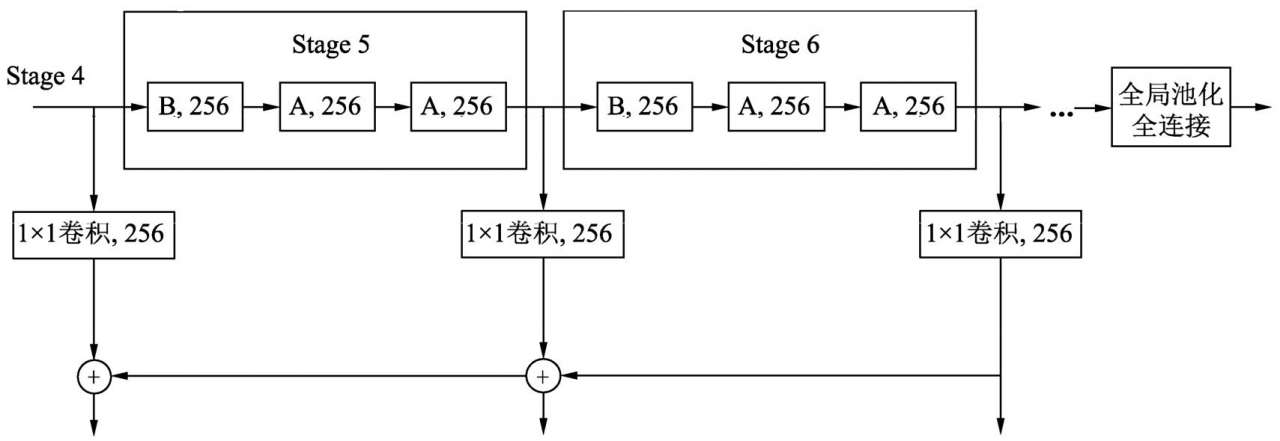

**DetNet这种精心设计的结构，在增加感受野的同时，获得了较大的特征图尺寸，有利于物体的定位。与此同时，由于各Stage的特征图尺寸相同，避免了上一节的上采样，既一定程度上降低了计算量，又有利于小物体的检测。**

DetNet中Bottleneck的细节如下图所示，左侧的两个BottleneckA与Bottleneck B分别对应上图的A与B，右侧的为原始的ResNet残差结构。DetNet与ResNet两者的基本思想都是卷积堆叠层与恒等映射的相加，区别在于DetNet使用了空洞数为2的3×3卷积，这样使得特征图尺寸保持不变，而ResNet是使用了步长为2的3×3卷积。B相比于A，在恒等映射部分增加了一个1×1卷积，这样做可以区分开不同的Stage，并且实验发现这种做法对于特征金字塔式的检测非常重要。

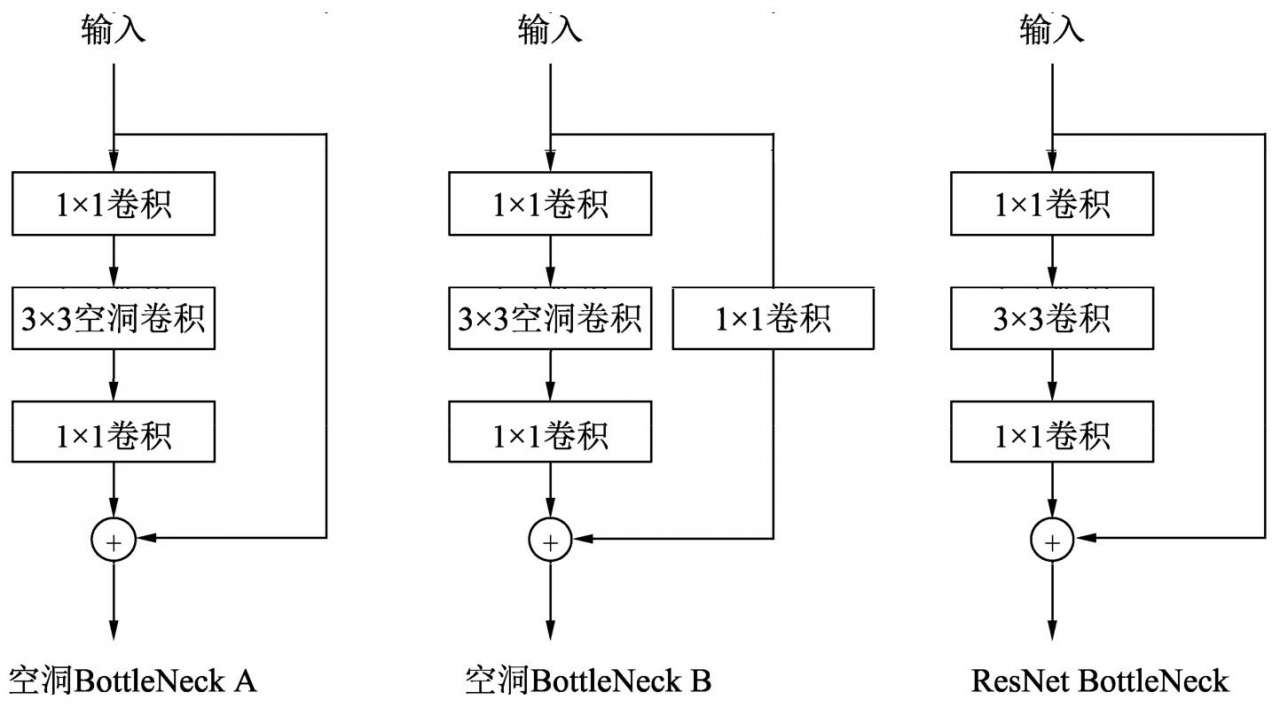

In [1]:
import torch
from detnet_bottleneck import DetBottleneck

In [2]:
#完成一个Stage5，即B-A-A结构，Stage4输出通道数为1024
bottleneck_b = DetBottleneck(1024, 256, 1, True ).cuda()
#查看Bottleneck B的结构，带有extra的卷积层
bottleneck_b

DetBottleneck(
  (bottleneck): Sequential(
    (0): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (relu): ReLU(inplace=True)
  (extra_conv): Sequential(
    (0): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [3]:
bottleneck_a1 = DetBottleneck(256, 256).cuda()
#查看Bottleneck A1的结构
bottleneck_a1

DetBottleneck(
  (bottleneck): Sequential(
    (0): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (relu): ReLU(inplace=True)
)

In [4]:
bottleneck_a2 = DetBottleneck(256, 256).cuda()
#查看Bottleneck A2的结构，与Bottleneck A1相同
bottleneck_a2

DetBottleneck(
  (bottleneck): Sequential(
    (0): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (relu): ReLU(inplace=True)
)

In [5]:
input = torch.randn(1, 1024, 14, 14).cuda()
#将input作为某一层的特征图，依次传入Bottleneck B、A1与A2三个模块
output1 = bottleneck_b(input)
output2 = bottleneck_a1(output1)
output3 = bottleneck_a2(output2)
#三个Bottleneck输出的特征图大小完全相同
output1.shape, output2.shape, output3.shape

(torch.Size([1, 256, 14, 14]),
 torch.Size([1, 256, 14, 14]),
 torch.Size([1, 256, 14, 14]))